# Plot and Analyze 

Next, title your notebook appropriately with a top-level Markdown header, `#`. Do not use this level header anywhere else in the notebook. Our book build process will use this title in the navbar, table of contents, etc. Keep it short, keep it descriptive. Follow this with a `---` cell to visually distinguish the transition to the prerequisites section.

---

## Overview

In this document we'll take our premade cloud regimes and create plots of the cluster centers and spatial distributions. You'll also learn how to extract data about a specific cloud regime. 

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intermediate NumPy](https://foundations.projectpythia.org/core/numpy/intermediate-numpy.html) | Necessary | |
| [Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| [Introduction to Pandas](https://foundations.projectpythia.org/core/pandas/pandas.html) | Helpful | Familiarity with labeled data |
| Project management | Helpful | |

- **Time to learn**: 15 minutes


---

## Imports

In [2]:
from Functions import plot_hists, plot_rfo, open_and_process
import logging as lgr
import xarray as xr
import numpy as np

## Defining Variables

Here we define the variables necesary to begin using the toy ISCCP dataset included with this cookbook. To start off leave these variables alone, but later on feel free to experiment. 

If running locally with your own dataset, you will need to change these to match your data.

In [3]:
# Path to data to cluster
data_path = "./ISCCP_toy_data.nc"

# Path to the directory you wish to save plots in if running as a script, if None plots will only be shown and not saved. Enter as String
save_path = None
save_prefix = None  # prefix to put into the name of each plot to distinguish different runs of this script

# Variable name of data to cluster in data_path
# Name of tau dimension for var_name
# Name of height/pressure dimension for var_name
var_name =  'n_pctaudist' 
tau_var_name =  'levtau' 
ht_var_name =  'levpc'
lat_var_name = 'lat'
lon_var_name = 'lon'

# Does this dataset use cloud top height or cloud top pressure? enter "h" for height or "p" for pressure
height_or_pressure = 'p'

# If you wish to only fit data into a set of premade CRs, set this equal to a path to a numpy ndarray of premade cloud regimes of
# shape=(k, n_tau_bins * n_pressure_bins). This will skip clustering and preform analysis with the premade regimes
# If used, the below kmeans properties are ignored, and k is set to premade_cloud_regimes.shape[0]
# Using this is different from setting init in kmeans properties to a set of CRs, as that will continue clustering using the premade 
# cloud regimes and update them. This will not update the cloud regimes and skips clustering entirely. It will only fit the data into these CRs
premade_cloud_regimes = None #'/project/amp02/idavis/isccp_clustering/modis_and_misr/modis_testing/MODIS_emd-means_n_init5_centers_1.npy'

# kmeans properties
k=6   # number of cluster to create
tol = 1000    # maximum change in inertia values between kmeans iterations to declare convergence. should be higher if using wasserstein distance
max_iter = 200   # maximum number of k-means iterations to preform for each initiation
init='k-means++'    # initialization technique for kmeans, can be 'k-means++', 'random', or initial clusters to use of shape (k, n_tau_bins * n_pressure_bins)
n_init = 1    # number of initiations of the k-means algorithm. The final result will be the initiation with the lowest calculated inertia
gpu = False  # If the user has an Nvidia GPU, euclidean clustering can be preformed on it for a very significant speed up. CUPY/CUML must be installed in conda environment.

# Choose whether to use a euclidean or wasserstein distance
wasserstein_or_euclidean = "euclidean"

# Minimum and Maximum longitudes and latitudes entered as list, or None for entire range
lat_range = [-90,90]
lon_range = [-180,180]

# Time Range min and max, or None for all time, entered as list of str: Ex. ["2003-03-01", "2004-07-01"] or ['2003','2007']
time_range = None

# Use data only over land or over ocean
# Set to 'L' for land only, 'O' for ocean only, or False for both land and ocean
only_ocean_or_land = False
# Does this dataset have a built in variable for land fraction? if so enter as a string, otherwise cartopy will be used to mask out land or water
land_frac_var_name = None

# Logging level, set to "INFO" for information about what the code is doing, otherwise keep at "WARNING"
logging_level = 'INFO'


# Setting up logger
lgr.root.setLevel(logging_level)
# Concatenating save_path and save prefix
if save_path != None: save_path = save_path + save_prefix

## Opening, Labeling and Plotting
Here we open our data, and assign each histogram to the nearest cluster. We store this information in an array named cluster_labels. After this we call plot_hists() to create plots of the CR centers, then we call plot_rfo() to create plots of the spatial distribution of each CR.

INFO:root: Opening dataset:
INFO:root: Opening finished. Beginning preprocessing:
INFO:root: Reshaping data to shape (n_histograms, n_tau_bins* n_pc_bins):
INFO:root: Reading data into memory:
INFO:root: Finished preprocessing:
INFO:root: Beginning clustering:
INFO:root: 1 seconds to cluster:


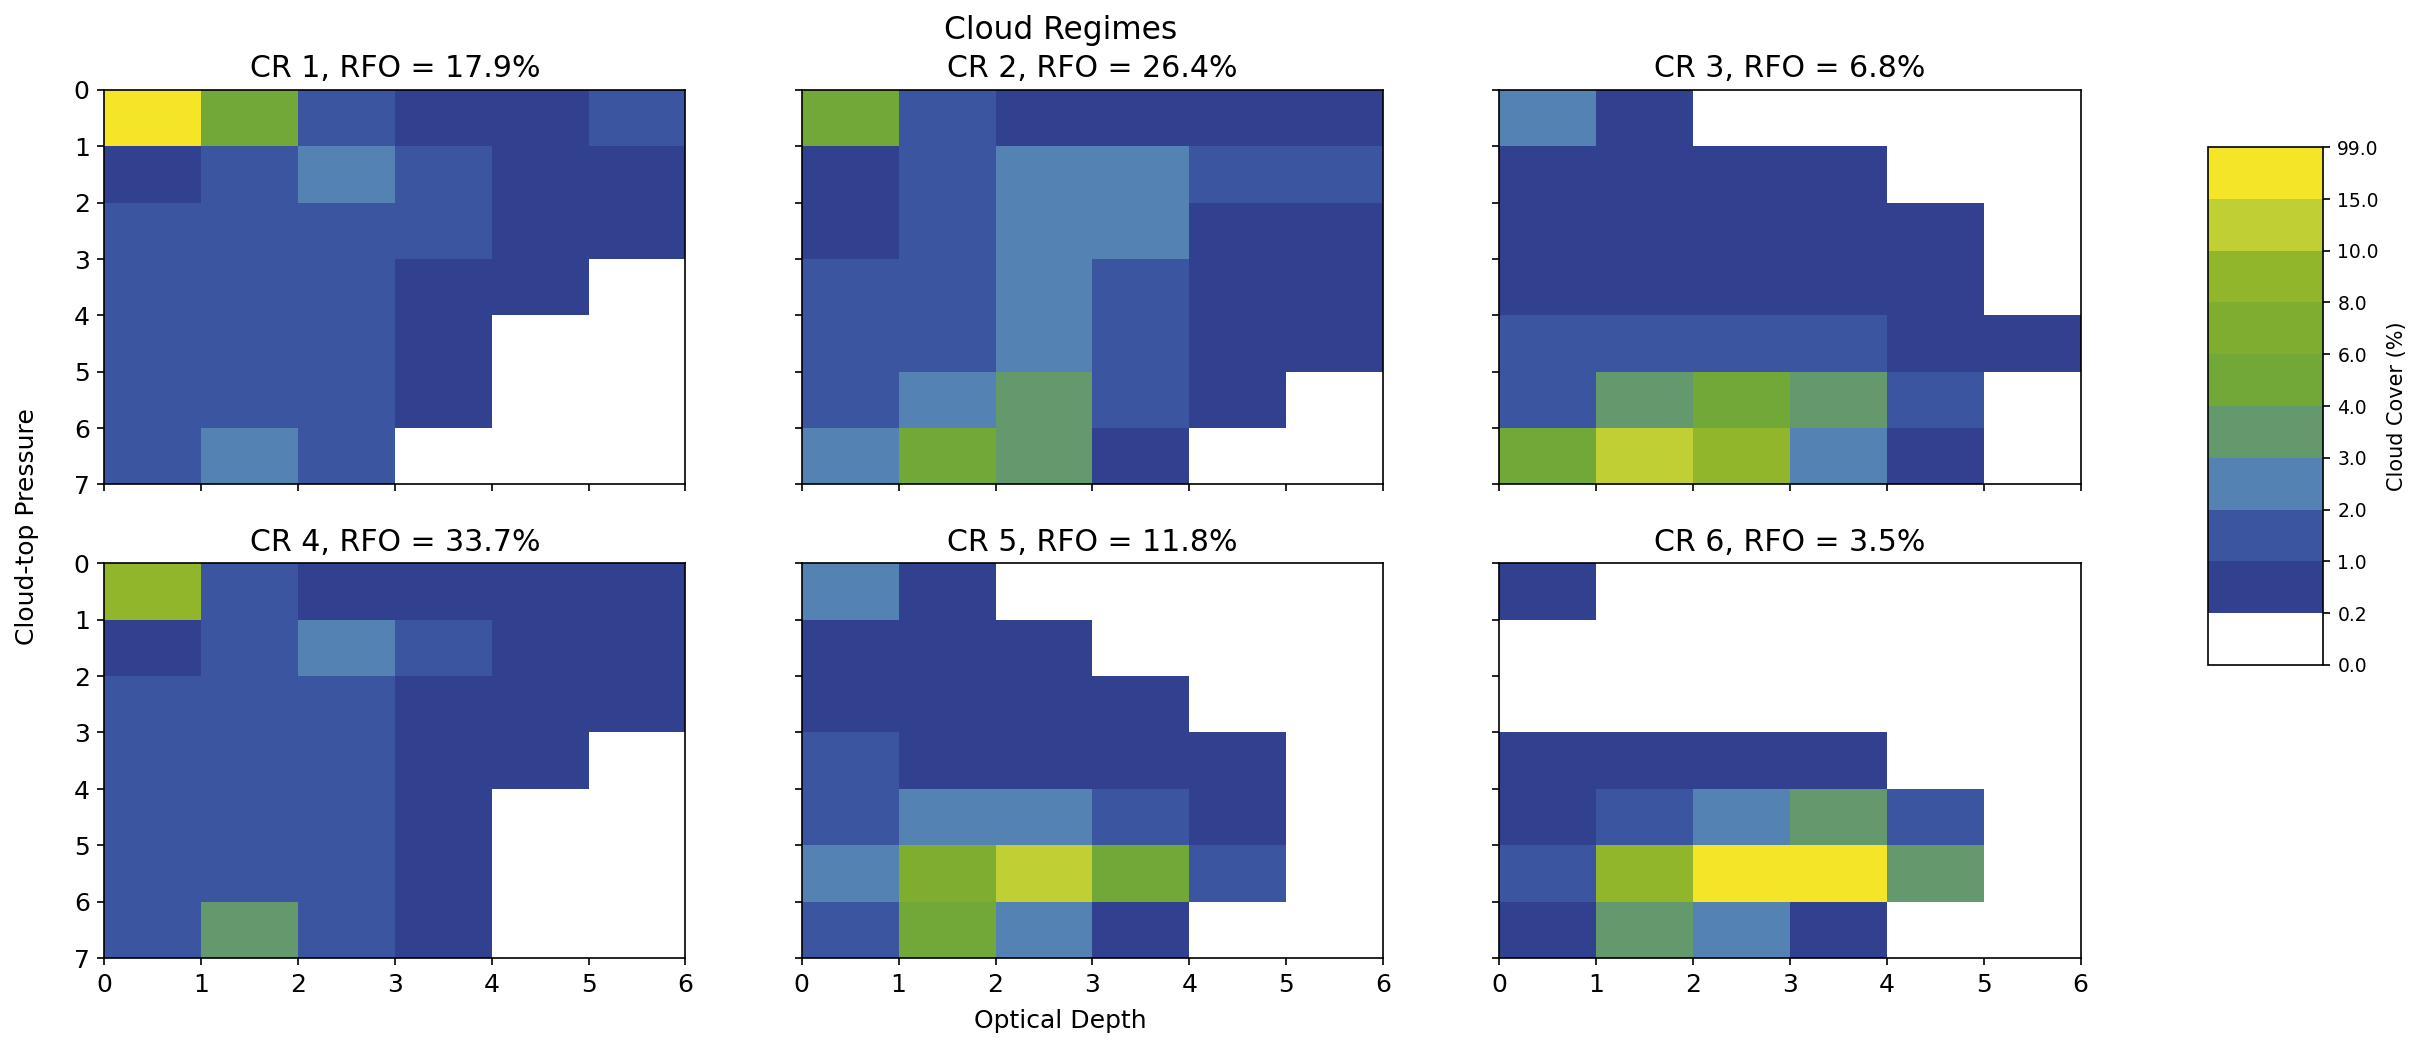

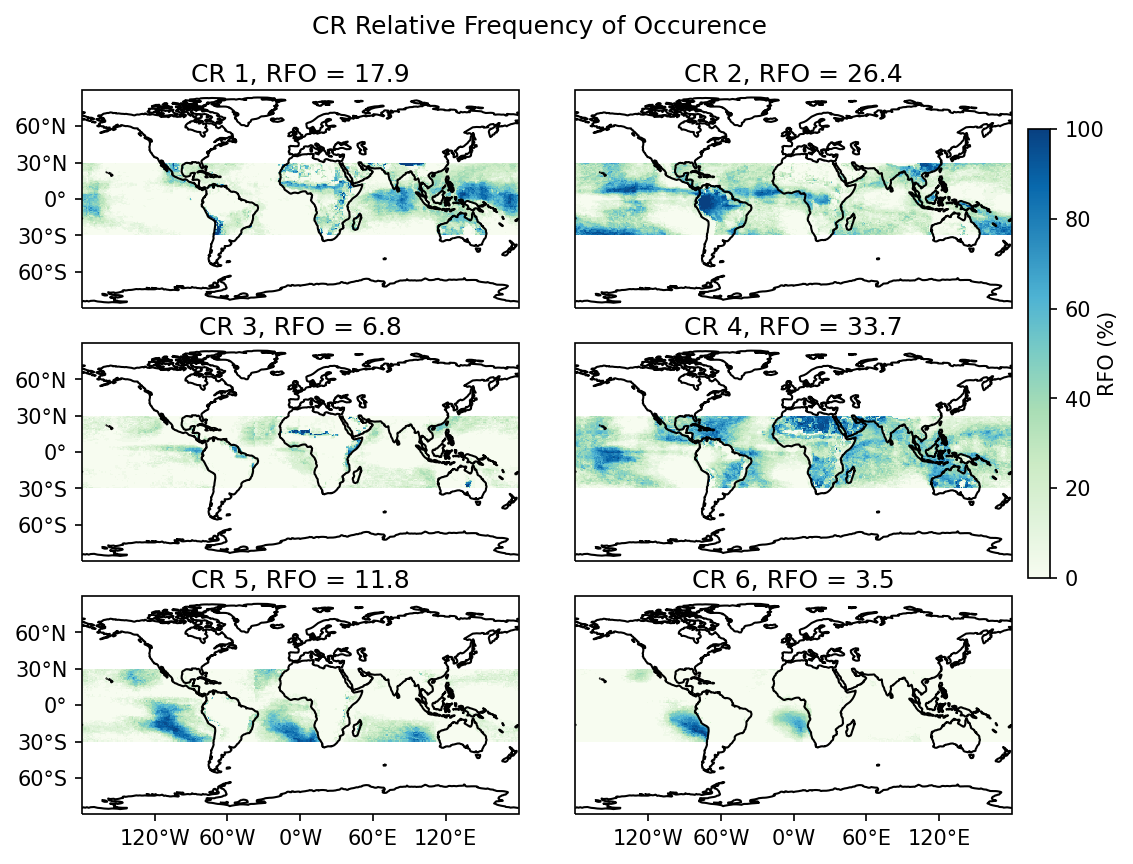

In [11]:
# Opening data, and clustering
mat, cluster_labels, cluster_labels_temp, valid_indicies, ds = open_and_process(data_path, k, tol, max_iter, init, n_init, var_name, tau_var_name, ht_var_name, lat_var_name, lon_var_name, height_or_pressure, wasserstein_or_euclidean, premade_cloud_regimes, lat_range, lon_range, time_range, only_ocean_or_land, land_frac_var_name, cluster=True, gpu=gpu)
# Plotting histograms
plot_hists(cluster_labels, k, ds, ht_var_name, tau_var_name, valid_indicies, mat, cluster_labels_temp, height_or_pressure, save_path)
# Plotting RFO
plot_rfo(cluster_labels, k ,ds, save_path)

## Further Analysis
This is all well and good, but this analysis only goes so far. It's likely a user will want to do some sort of further analysis beyond looking at the spacial distributions of the CRs. In this section you will learn how to do this. 

Described above, we create an array called cluster_labels that holds the cluster that each histogram belongs to. Here's how to use it:

First lets re-open the dataset specified by the data_path variable, since all the variables other than the one stored in var_name are automatically removed. 

In [6]:
ds = xr.open_mfdataset(data_path)
ds

<xarray.Dataset>
Dimensions:      (time: 24, lon: 360, lat: 60, levpc: 7, levtau: 6)
Coordinates:
  * time         (time) datetime64[ns] 2013-07-16T10:30:00 ... 2015-06-15T22:...
  * lon          (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat          (lat) float32 -29.5 -28.5 -27.5 -26.5 ... 26.5 27.5 28.5 29.5
  * levpc        (levpc) float32 95.0 245.0 375.0 500.0 620.0 740.0 912.5
  * levtau       (levtau) float32 0.5 2.3 6.0 14.5 34.74 109.8
Data variables:
    n_pctaudist  (time, levtau, levpc, lat, lon) float32 dask.array<chunksize=(24, 6, 7, 60, 360), meta=np.ndarray>
    pc           (time, lat, lon) float32 dask.array<chunksize=(24, 60, 360), meta=np.ndarray>
Attributes: (12/67)
    Conventions:                              CF-1.6, ACDD-1.3
    summary:                                  The HGG product represents glob...
    keywords:                                 EARTH SCIENCE > ATMOSPHERE > AT...
    keywords_vocabulary:                      NASA Global Change Master Direc...
    platform_vocabulary:                      NASA Global Change Master Direc...
    instrument_vocabulary:                    NASA Global Change Master Direc...
    ...                                       ...
    geospatial_lon_min:                       0.0
    geospatial_lon_max:                       360.0
    geospatial_lon_resolution:                1.0
    geospatial_vertical_min:                  10.0
    geospatial_vertical_max:                  1025.0
    history:                                  Mon Jul  3 15:52:50 2017: ncatt...

The optical depth - cloud top height joint histograms should be stored in ds under the variable entered as var_name, such that ds[var_name] opens the raw histogram data. For ISCCP, this data is in the shape (n_time, n_tau, n_pressures, n_lat, n_lon) where n_time, n_tau, n_pressures... are the number of times, tau bins, pressure bins etc that are present in the dataarray. Other data products will be roughly similar to this, but may have the dimesnions in a different order. cluster_labels is an array of integers in (almost) this same shape, but without n_tau and n_pressure dimensions. So in this case cluster labels is shape (n_time, n_lat, n_lon). The value of cluster_labels[specific_time, specific_lat, specific_lon] will be an integer ranging from 0 to k-1 that indicates which CR the histogram located at ds[var_name][specific_time,:,:, specific_lat, specific_lon] belongs to. This may be slightly confusing, but a value of 0 indicates this histogram belongs to CR1, a value of 1 indicates it belongs to CR2 and etc... This indexing works better for some operations in python, but if it truly displeases you, there is a very easy fix. After all of the pre-written function calls, simply add the line "cluster_labels += 1", which will reindex the values to run from 1 through k, where each value is directly equal to the CR the corresponding histogram has been labeled as. It is also important to note that any histogram that conatains a NaN will not be assigned a cluster, and the value in cluster labels will also be NaN.

Now that we understand the structure of the cluster_labels array, lets go over how to use it. As can be seen above, our ds has two variables: n_pctaudist which holds the histogram data, and pc which holds the mean cloud-top pressure for cloudy pixels in each histogram. We will use the cluster labels array and the pc variable to calculate the mean cloud-top pressure for each CR. (Yes this could also be calculated from the raw histogram data, but here we use a seperate variable for illustration purposes)

Now, lets create a dataarray of the mean cloud-top pressures

In [8]:
pc = ds.pc

Then we can loop through each CR, and calculate the average cloud top pressure. We do this with the dataarray.where() function provided by xarray. This function (used on line 2 in the following cell) allows us to grab all the values of pc where cluster_labels is equal to a certain cluster, and maske out all the other values. We can then take the mean of this to get the mean cloud top pressure for a certain cluster. 

This method can be extended to be used on any variable, not just caverage cloud top pressure. It is also possible to remove the for loop in the below cell, and preform this operation using only broadcasting and vectorization if one wishes. 

In [28]:
# Looping through each cluster
for cr in range(k):
    # Grabbing the values of pc for histograms assigned to cr
    pc_of_cr = pc.where(cluster_labels == cr)
    # Calculating the mean cloud top pressure
    average_cloud_top_pressure = np.nanmean(pc_of_cr)
    # Printing results
    print(f"The average cloud top pressure of CR{cr+1} is {average_cloud_top_pressure} ")


The average cloud top pressure of CR1 is 400.5481262207031 
The average cloud top pressure of CR2 is 581.3370361328125 
The average cloud top pressure of CR3 is 728.1123657226562 
The average cloud top pressure of CR4 is 531.5059204101562 
The average cloud top pressure of CR5 is 687.6305541992188 
The average cloud top pressure of CR6 is 719.5713500976562 


### Subsection to the second section

#### a quick demonstration

##### of further and further

###### header levels

as well $m = a * t / h$ text! Similarly, you have access to other $\LaTeX$ equation [**functionality**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html) via MathJax (demo below from link),

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

Check out [**any number of helpful Markdown resources**](https://www.markdownguide.org/basic-syntax/) for further customizing your notebooks and the [**Jupyter docs**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html) for Jupyter-specific formatting information. Don't hesitate to ask questions if you have problems getting it to look *just right*.

In [44]:
np_cl = cluster_labels.values.flatten()
np_pc = pc.values.flatten()
one_hot_matrix = labels[:,None] == np_cl
b_data, b_oh = np.broadcast_arrays(np_pc[:,None], one_hot_matrix[:,:,None])
centroids =  b_data.mean(axis=0, where=b_oh)
print(centroids)




[[665.14404]
 [679.36664]
 [687.80414]
 ...
 [563.379  ]
 [608.57806]
 [710.219  ]]


/tmp/ipykernel_17615/486085737.py:5: RuntimeWarning: Mean of empty slice.
  centroids =  b_data.mean(axis=0, where=b_oh)
/project/amp02/idavis/miniconda3/envs/clustering/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


## Last Section

If you're comfortable, and as we briefly used for our embedded logo up top, you can embed raw html into Jupyter Markdown cells (edit to see):

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Your relevant information here!
</div>

Feel free to copy this around and edit or play around with yourself. Some other `admonitions` you can put in:

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    We got this done after all!
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Be careful!
</div>

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Danger</p>
    Scary stuff be here.
</div>

We also suggest checking out Jupyter Book's [brief demonstration](https://jupyterbook.org/content/metadata.html#jupyter-cell-tags) on adding cell tags to your cells in Jupyter Notebook, Lab, or manually. Using these cell tags can allow you to [customize](https://jupyterbook.org/interactive/hiding.html) how your code content is displayed and even [demonstrate errors](https://jupyterbook.org/content/execute.html#dealing-with-code-that-raises-errors) without altogether crashing our loyal army of machines!

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!